#Coding Environment

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
#df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/Metro_Interstate_Traffic_Volume.csv')

train_df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_train.csv')
val_df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_validate.csv')
test_df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_test.csv')

# Data Windowing

Rather than setting predifined functions to determine which of their ordering resulted in the model best fit (as in the case of the SARIMAX statistical model), neural networks derive their own function to determine a best possible fit. This processual difference is however achieved by data-windowing, by defining a sequence of data points 

In [5]:
class DataWindow():
  # Initialise a DataWindow object
  def __init__(self, input_width, label_width, shift, train_df=train_df, 
             val_df=val_df, test_df=test_df, label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    
    # Name of column to predict
    self.label_columns = label_columns
    if label_columns is not None:
      # Dict. of name and index of label column. Used for plotting.
      self.label_columns_indices = {name: i for i, name in 
                                    enumerate(label_columns)}
    # Dict. of name and index of each column. Used for plotting.
    # Used to seperate the features from target variable
    self.column_indices = {name: i for i, name in 
                                    enumerate(train_df.columns)}
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift
    # Returns a slice object that specifies how to slice a sequence.
    # In this case, it says that hte input slice starts at 0, ends when 
    # input_width is reached
    self.input_slice = slice(0, input_width)
      
    # Assign indices to the inputs. These are usefull for plotting.
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
      
    # Get the index at which the label starts. In this case, it's the total 
    # window size less the width of the label.
    self.label_start = self.total_window_size - self.label_width
    # Repeat steps applied for input for labels
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
  
  # Seperate the big data window into two windows: one for inputs, 
  # the other for the lables
  def split_to_inputs_labels(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns], 
          axis=-1
      )
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  # Plot sample of data windows
  def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
    inputs, labels=self.sample_batch

    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))

    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [scaled]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index], 
               label='Inputs', marker='.', zorder=-10)
      
      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue  
      
      plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                  edgecolors='k', marker='s', label='Labels', c='green', s=64)
      
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions', c='red', 
                    s=64)
      
      if n == 0:
        plt.legend()
    
    plt.xlabel('Time (h)')
  
  # Format dataset into tensors, fed to dl model.
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    # Use tensor timeseries_dataset_from_array function to create a dataset of 
    # sliding windows.
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data = data,
        # targets are handled by the split_to_input_labels function, 
        # thus set to none.
        targets = None,
        sequence_length = self.total_window_size,
        # Number of timesteps seperating each sequence.
        # In this case sequences are consecutive hence sequence_stride equall 1
        sequence_stride = 1,
        # Shuffle the batch sequence, not the window/sequence timesteps
        shuffle = True,
        # Sequences in a batch
        batch_size=32
    )

    ds = ds.map(self.split_to_inputs_labels)
    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)
    
  @property
  def val(self):
    return self.make_dataset(self.val_df)
    
  @property
  def test(self):
    return self.make_dataset(self.test_df)
    
  @property
  def sample_batch(self):
    result = getattr(self, '_sample_batch', None)
    if result is None:
      result = next(iter(self.train))
      self._sample_batch = result
    return result

# Baseline Models

## Single-step Baseline Model

In [6]:
# Create single-step baseline Model
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [7]:
# The Baseline class is a subclass of Tensorflow
class Baseline(Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index
        
  def call(self, inputs):
    # Return all columns if no target is specified.
    # Usefull for multi-output models where all columns are predicted.
    if self.label_index is None:
      return inputs
    # Specify a list of columns to be predicted- 
    # as in the case of a multi-output model. 
    elif isinstance(self.label_index, list):
      tensors = []
      for index in self.label_index:
        result = inputs[:, :, index]
        result = result[:, :, tf.newaxis]
        tensors.append(result)
      return tf.concat(tensors, axis=-1)
        
    result = inputs[:, :, self.label_index]
    return result[:,:,tf.newaxis]

In [8]:
# A dictionary for the name and index of each column in the training set.
column_indices = {name: i for i, name in enumerate(train_df.columns)}
# Pass index of the target column in the Baseline class.
baseline_last = Baseline(label_index=column_indices['traffic_volume'])
# Compile model to generate predictions
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [9]:
# Dictionary to hold the MAE of a model on a validation set.
val_performance = {}
# Dictionary to hold the MAE of a model on the test set.
performance =  {}
# Store the MAE of the baseline on the validation set.
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
# Store the MAE of the baseline on the test set.
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 1s 4ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


In [ ]:
wide_window.plot(baseline_last)

## Multi-Step Baseline Model

Next we predict more than one timestep into the future. Forecast the traffic volume for the following 24 hours of data given an input of 24 hours. Generate a fitting data window. Since we are predicting 24 timesteps into the future with an input of 24 *hours*, the input width, label width, and shift will be 24.

In [10]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, 
                          label_columns=['traffic_volume'])

### Predict the last known value for the next 24 hours

In [11]:
class MultiStepLastBaseline(Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      # Return the last known value of the target column over the next 
      # 24 timesteps.
      return tf.tile(inputs[:, -1:, :], [1, 24, 1])
    # Return the last known value of all columns over the next 24 hours 
    # if no target is specified.
    return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [12]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 6ms/step - loss: 0.1874 - mean_absolute_error: 0.3520


In [ ]:
multi_window.plot(ms_baseline_last)

In [15]:
print(ms_val_performance['Baseline - Last'][1])

0.34706422686576843


### Predict the last 24 hrs for the next 24 timesteps

In [13]:
class RepeatBaseline(Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    # Return the input sequence for the given time column
    return inputs[:, :, self.label_index:]

In [14]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)

ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 4ms/step - loss: 0.2125 - mean_absolute_error: 0.3533


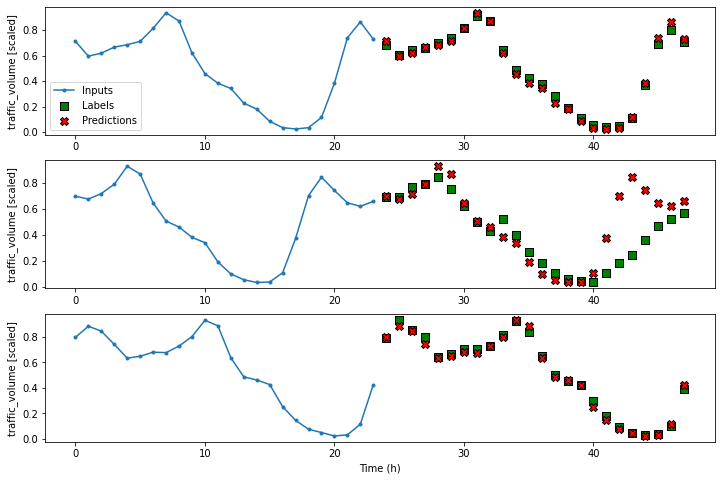

In [29]:
multi_window.plot(ms_baseline_repeat)

In [18]:
print(ms_performance['Baseline - Repeat'][1])

0.343904584646225


## Multi-output Baseline Model

Predict more than one out, that is, predict the traffic volumen and temperature by way of a single step model. 

In [15]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp', 'traffic_volume'])
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['temp', 'traffic_volume'])

In [16]:
ci_traffic_volume = column_indices['traffic_volume']
ci_temp = column_indices['temp']

In [17]:
mo_baseline_last = Baseline(label_index=[ci_traffic_volume, ci_temp])
mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 1s 4ms/step - loss: 0.1422 - mean_absolute_error: 0.3127


In [ ]:
mo_wide_window.plot(mo_baseline_last)

In [ ]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [32]:
print(mo_performance['Baseline - Last'])

[0.17616763710975647, 0.35056373476982117]


# Linear Model

A linear model is deep learning model without a hidden layer. Strictly speaking, a linear model in this respect is in fact not a deep deep learning since its devoid of a hidden layer. Hence the model equation resembles the function of a multivariate linear model.  

## Single-step Linear model

In [18]:
# DEF: Configure deep learning model and fit data.
# patience: number of epochs after which model stops training-
# granted the validation loss does not improve.
# max_epochs: maximum number of epochs to train the model. Method stops when 3- 
# consecutive epochs do not decrease the validation loss.
def compile_and_fit(model, window, patience=3, max_epochs=50):
  early_stopping = EarlyStopping(monitor='val_loss', 
                                 patience=patience, 
                                 mode='min')
  
  model.compile(loss=MeanSquaredError(),
                # Adam's an optimiser proivding a method that descends the 
                # gradient applied to the weights of the layers.
                optimizer=Adam(),
                metrics=[MeanAbsoluteError()])
  
  history = model.fit(window.train, 
                      epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  
  return history

In [19]:
# Sequential, a kerras model, allows the stacking of different layers
linear = Sequential([Dense(units=1)])
history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 5s 6ms/step - loss: 22450518.0000 - mean_absolute_error: 4062.5679 - val_loss: 48995004.0000 - val_mean_absolute_error: 6981.4824
Epoch 2/50
384/384 [==============================] - 2s 6ms/step - loss: 7025642.5000 - mean_absolute_error: 2257.4595 - val_loss: 12713613.0000 - val_mean_absolute_error: 3556.3574
Epoch 3/50
384/384 [==============================] - 2s 6ms/step - loss: 1571013.2500 - mean_absolute_error: 1054.4224 - val_loss: 2170553.5000 - val_mean_absolute_error: 1469.4452
Epoch 4/50
384/384 [==============================] - 2s 6ms/step - loss: 224817.7031 - mean_absolute_error: 390.8569 - val_loss: 217388.1875 - val_mean_absolute_error: 465.0244
Epoch 5/50
384/384 [==============================] - 2s 6ms/step - loss: 18499.5527 - mean_absolute_error: 108.4781 - val_loss: 11734.6426 - val_mean_absolute_error: 108.0280
Epoch 6/50
384/384 [==============================] - 4s 10ms/step - loss: 787.9290 - mean_absolu

In [ ]:
wide_window.plot(linear)

## Multi-Step Linear Model

In [20]:
# Initialise the weights to 0, to make training slightly faster
ms_linear = Sequential([Dense(1, kernel_initializer=tf.initializers.zeros)])
history = compile_and_fit(ms_linear, multi_window)
ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 3s 7ms/step - loss: 0.6998 - mean_absolute_error: 0.4269 - val_loss: 0.2610 - val_mean_absolute_error: 0.4409
Epoch 2/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0720 - mean_absolute_error: 0.2247 - val_loss: 0.0936 - val_mean_absolute_error: 0.2495
Epoch 3/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0458 - mean_absolute_error: 0.1773 - val_loss: 0.0388 - val_mean_absolute_error: 0.1628
Epoch 4/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0381 - mean_absolute_error: 0.1558 - val_loss: 0.1393 - val_mean_absolute_error: 0.3397
Epoch 5/50
383/383 [==============================] - 2s 6ms/step - loss: 0.1245 - mean_absolute_error: 0.2251 - val_loss: 0.0369 - val_mean_absolute_error: 0.1581
Epoch 6/50
383/383 [==============================] - 3s 8ms/step - loss: 0.0331 - mean_absolute_error: 0.1341 - val_loss: 0.0434 - val_mean_absolute_error: 0.1753
Epoch 7/50
383/3

In [ ]:
wide_window.plot(ms_linear)

## Multi-Output Linear Model

In [21]:
mo_linear = Sequential([Dense(units=2)])
history = compile_and_fit(mo_linear, mo_single_step_window)
mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 3s 7ms/step - loss: 5092840.0000 - mean_absolute_error: 1853.0967 - val_loss: 5868061.0000 - val_mean_absolute_error: 2335.9143
Epoch 2/50
384/384 [==============================] - 3s 6ms/step - loss: 526208.5625 - mean_absolute_error: 548.6042 - val_loss: 330250.9062 - val_mean_absolute_error: 509.6618
Epoch 3/50
384/384 [==============================] - 2s 6ms/step - loss: 22835.7617 - mean_absolute_error: 98.2181 - val_loss: 6759.8799 - val_mean_absolute_error: 65.2560
Epoch 4/50
384/384 [==============================] - 2s 6ms/step - loss: 358.6515 - mean_absolute_error: 10.3875 - val_loss: 44.6700 - val_mean_absolute_error: 5.3763
Epoch 5/50
384/384 [==============================] - 3s 6ms/step - loss: 2.2924 - mean_absolute_error: 1.0714 - val_loss: 1.2440 - val_mean_absolute_error: 1.0410
Epoch 6/50
384/384 [==============================] - 2s 6ms/step - loss: 0.6991 - mean_absolute_error: 0.6742 - val_loss: 0.9885 - val

In [ ]:
mo_wide_window.plot(mo_linear)

In [ ]:
mo_wide_window.plot(model=mo_linear, plot_col='temp')

# Deep Neural Network (DNN)

## Single-Step DNN Model

In [22]:
# Activation function: Relu (i.e., rectified linear unit)
# Hidden Layers: 2
# Neurons: 64
dense = Sequential([Dense(units=64, activation='relu'),
                    Dense(units=64, activation='relu'),
                    Dense(units=1)])
# Compile, train, and evaluate model performance
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 4s 8ms/step - loss: 14588.1807 - mean_absolute_error: 26.9564 - val_loss: 0.1351 - val_mean_absolute_error: 0.2993
Epoch 2/50
384/384 [==============================] - 4s 9ms/step - loss: 2.1745 - mean_absolute_error: 0.7041 - val_loss: 0.2189 - val_mean_absolute_error: 0.4024
Epoch 3/50
384/384 [==============================] - 3s 8ms/step - loss: 0.2263 - mean_absolute_error: 0.3331 - val_loss: 0.1487 - val_mean_absolute_error: 0.3178
Epoch 4/50
110/110 [==============================] - 1s 5ms/step - loss: 0.3252 - mean_absolute_error: 0.5146


In [ ]:
wide_window.plot(dense)

### Compare Models (Linear vs DNN)

In [ ]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', 
       label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black',
       hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
  plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha = 'center')
  
for index, value in enumerate(mae_test):
  plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

In [28]:
?tf.test.gpu_device_name()

Object `tf.test.gpu_device_name()` not found.



## Multi-Output DNN Model

In [27]:
mo_dense = Sequential([Dense(units=64, activation='relu'),
                       Dense(units=64, activation='relu'),
                       Dense(units=2)])
# %load_ext tensorboard
# %tensorboard --logdir logs
history = compile_and_fit(mo_dense, mo_single_step_window)
mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 4s 8ms/step - loss: 748.9320 - mean_absolute_error: 6.7025 - val_loss: 0.2213 - val_mean_absolute_error: 0.4168
Epoch 2/50
384/384 [==============================] - 3s 8ms/step - loss: 0.2582 - mean_absolute_error: 0.3840 - val_loss: 0.3526 - val_mean_absolute_error: 0.4854
Epoch 3/50
384/384 [==============================] - 3s 9ms/step - loss: 0.1389 - mean_absolute_error: 0.3067 - val_loss: 0.0532 - val_mean_absolute_error: 0.1967
Epoch 4/50
384/384 [==============================] - 3s 8ms/step - loss: 3.2066 - mean_absolute_error: 0.7555 - val_loss: 5.1514 - val_mean_absolute_error: 2.2174
Epoch 5/50
384/384 [==============================] - 3s 8ms/step - loss: 6.2790 - mean_absolute_error: 0.8559 - val_loss: 0.9005 - val_mean_absolute_error: 0.9231
Epoch 6/50
110/110 [==============================] - 1s 5ms/step - loss: 265.3977 - mean_absolute_error: 16.2205


In [ ]:
mo_mae_val = [v[1] for v in val_performance.values()]
mo_mae_test = [v[1] for v in performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', 
       label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black',
       hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
  plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha = 'center')
  
for index, value in enumerate(mo_mae_test):
  plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()